In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [142]:
# Load the feature matrix from the CSV file
df = pd.read_csv('./Data/features_3_sec.csv')

# Drop the filename column
df = df.drop('filename', axis=1)

In [143]:
# Exploring the data
print(df.head())

   length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var   
0   66149          0.335406         0.091048  0.130405  0.003521  \
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean   
0             1773.065032          167541.630869              1972.744388  \
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean   
0           117335.771563   3714.560359  ...   39.68714

In [144]:
print(df.shape)

(9990, 59)


In [145]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   length                   9990 non-null   int64  
 1   chroma_stft_mean         9990 non-null   float64
 2   chroma_stft_var          9990 non-null   float64
 3   rms_mean                 9990 non-null   float64
 4   rms_var                  9990 non-null   float64
 5   spectral_centroid_mean   9990 non-null   float64
 6   spectral_centroid_var    9990 non-null   float64
 7   spectral_bandwidth_mean  9990 non-null   float64
 8   spectral_bandwidth_var   9990 non-null   float64
 9   rolloff_mean             9990 non-null   float64
 10  rolloff_var              9990 non-null   float64
 11  zero_crossing_rate_mean  9990 non-null   float64
 12  zero_crossing_rate_var   9990 non-null   float64
 13  harmony_mean             9990 non-null   float64
 14  harmony_var             

In [146]:
# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
class MusicGenreDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MusicGenreDataset(X_train, y_train)
test_dataset = MusicGenreDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [148]:
class CNN(nn.Module):
	def __init__(self, num_classes):
		super(CNN, self).__init__()
		self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
		self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
		self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
		self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
		self.dropout = nn.Dropout(0.2)
		self.batch_norm1 = nn.BatchNorm1d(64)
		self.batch_norm2 = nn.BatchNorm1d(128)
		self.batch_norm3 = nn.BatchNorm1d(256)

		# Compute the flattened size for the fully connected layer
		self._to_linear = None
		self.convs(torch.randn(1, 1, 60))
		
		self.fc1 = nn.Linear(self._to_linear, 512)
		self.fc2 = nn.Linear(512, 256)
		self.fc3 = nn.Linear(256, num_classes)

	def convs(self, x):
		x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
		x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
		x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))

		if self._to_linear is None:
			self._to_linear = x.shape[1] * x.shape[2]
		
		return x

	def forward(self, x):
		x = x.unsqueeze(1)  # Add channel dimension
		x = self.convs(x)
		x = x.view(x.size(0), -1)  # Flatten the tensor
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		x = self.dropout(x)
		x = self.fc3(x)
		return x

In [152]:
# Create the model
num_classes = len(np.unique(y_train))
model = CNN(num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
best_val_loss = float('inf')
num_epochs = 15
for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0
	for inputs, labels in train_loader:
		inputs, labels = inputs.to(device), labels.to(device)

		optimizer.zero_grad()
		outputs = model(inputs)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()

	print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

	# Validation
	model.eval()
	val_loss = 0.0
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			val_loss += loss.item()

	print(f'Validation Loss: {val_loss/len(test_loader):.4f}')

	if val_loss < best_val_loss:
		best_val_loss = val_loss
		torch.save(model.state_dict(), 'Best_DL_Models/MFCC_best_model.pth')

	scheduler.step()


Epoch [1/15], Loss: 1.2447
Validation Loss: 0.9606
Epoch [2/15], Loss: 0.8102
Validation Loss: 0.7443
Epoch [3/15], Loss: 0.6004
Validation Loss: 0.5251
Epoch [4/15], Loss: 0.4651
Validation Loss: 0.5234
Epoch [5/15], Loss: 0.3628
Validation Loss: 0.4235
Epoch [6/15], Loss: 0.2913
Validation Loss: 0.4431
Epoch [7/15], Loss: 0.2345
Validation Loss: 0.4582
Epoch [8/15], Loss: 0.1047
Validation Loss: 0.3039
Epoch [9/15], Loss: 0.0661
Validation Loss: 0.2935
Epoch [10/15], Loss: 0.0489
Validation Loss: 0.3030
Epoch [11/15], Loss: 0.0404
Validation Loss: 0.2973
Epoch [12/15], Loss: 0.0327
Validation Loss: 0.2960
Epoch [13/15], Loss: 0.0301
Validation Loss: 0.3065
Epoch [14/15], Loss: 0.0283
Validation Loss: 0.3106
Epoch [15/15], Loss: 0.0236
Validation Loss: 0.3012


              precision    recall  f1-score   support

       blues       0.90      0.90      0.90       208
   classical       0.94      0.97      0.95       203
     country       0.88      0.90      0.89       186
       disco       0.93      0.86      0.89       199
      hiphop       0.91      0.91      0.91       218
        jazz       0.90      0.92      0.91       192
       metal       0.96      0.96      0.96       204
         pop       0.91      0.92      0.92       180
      reggae       0.90      0.90      0.90       211
        rock       0.85      0.84      0.84       197

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



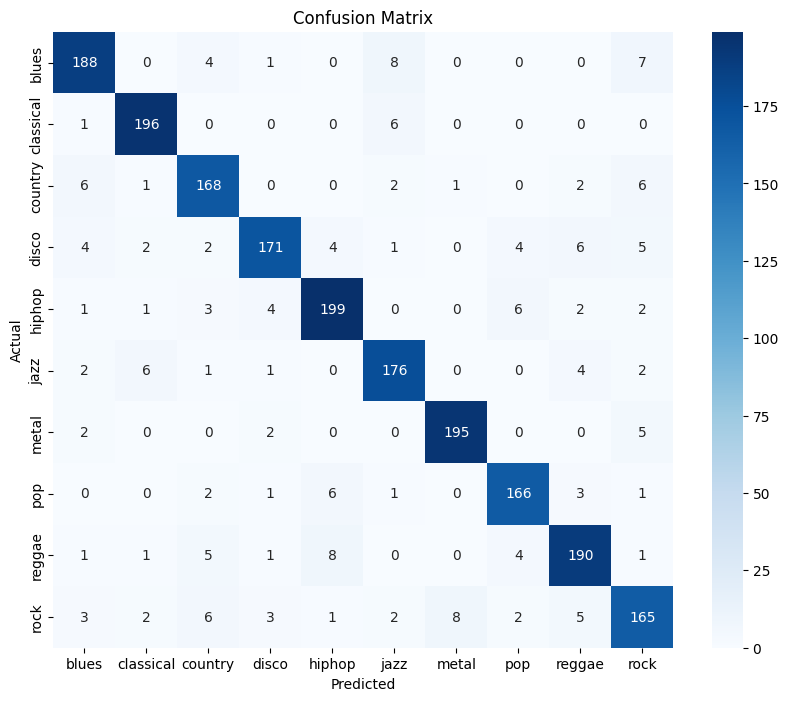

In [153]:
# Load and evaluate the best pre-trained model on the validation set
model.load_state_dict(torch.load('Best_DL_Models/MFCC_best_model.pth'))

# Classification report
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
	for inputs, labels in test_loader:
		inputs, labels = inputs.to(device), labels.to(device)
		outputs = model(inputs)
		_, predicted = torch.max(outputs.data, 1)
		y_pred.extend(predicted.cpu().numpy())
		y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=labelencoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()